# Analysis of Grinding Simulation Data

In [1]:
from platform import python_version
python_version()

'3.7.6'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

In [3]:
plot_dir = '../../plots'
data_dir = '../../data'

## Simulation 1 - Open Loop System

In [4]:
# Read data from file
data_filename = 'sim_ss_2020-04-13.csv'
filepath = os.path.join(data_dir, data_filename)
sim_data = pd.read_csv(filepath)
nt = sim_data.shape[0]
sim_data.shape

(11000, 82)

In [5]:
sim_data.head()

,Timestep,Time (mins),Charge Filling (%),Speed (% Critical),Power (kW),Make-up Feed [1],Make-up Feed [2],Make-up Feed [3],Make-up Feed [4],Make-up Feed [5],...,Mill Discharge [18],Mill Discharge [19],Mill Discharge [20],Mill Discharge [21],Mill Discharge [22],Mill Discharge [23],Mill Discharge [24],Mill Discharge [25],Net Feedrate (ton/hr),Mill Discharge (ton/hr)
0,0.0,0.5,51.293234,68.0,8992.045174,0.640239,0.959246,1.364199,2.616283,3.435867,...,1.165436,1.082931,0.946418,0.873010,0.950730,0.761578,0.651125,4.965763,1600.0,2060.479603
1,1.0,1.0,51.012210,68.0,9012.246786,0.730177,0.486831,0.977774,2.787712,2.867663,...,1.262394,1.208038,1.070895,1.076396,1.136143,0.938579,0.777012,5.910289,1600.0,2177.729715
2,2.0,1.5,50.689461,68.0,9034.815426,0.449112,1.467526,1.437201,2.362017,3.177435,...,1.247580,1.170740,1.120762,1.129246,1.246792,1.045256,0.923257,6.505925,1600.0,2222.305998
3,3.0,2.0,50.351224,68.0,9057.741521,0.543683,0.511191,1.626371,2.710941,2.412677,...,1.154680,1.190298,1.177991,1.165198,1.257861,1.096584,0.987502,6.865916,1600.0,2238.458224
4,4.0,2.5,50.010173,68.0,9080.106468,0.317217,0.984287,1.305303,2.259159,2.580799,...,1.087499,1.224770,1.158112,1.183705,1.237762,1.158198,0.990956,7.163079,1600.0,2234.984669


In [6]:
sim_data.columns

Index(['Timestep', 'Time (mins)', 'Charge Filling (%)', 'Speed (% Critical)',
       'Power (kW)', 'Make-up Feed [1]', 'Make-up Feed [2]',
       'Make-up Feed [3]', 'Make-up Feed [4]', 'Make-up Feed [5]',
       'Make-up Feed [6]', 'Make-up Feed [7]', 'Make-up Feed [8]',
       'Make-up Feed [9]', 'Make-up Feed [10]', 'Make-up Feed [11]',
       'Make-up Feed [12]', 'Make-up Feed [13]', 'Make-up Feed [14]',
       'Make-up Feed [15]', 'Make-up Feed [16]', 'Make-up Feed [17]',
       'Make-up Feed [18]', 'Make-up Feed [19]', 'Make-up Feed [20]',
       'Make-up Feed [21]', 'Make-up Feed [22]', 'Make-up Feed [23]',
       'Make-up Feed [24]', 'Make-up Feed [25]', 'Internal Charge [1]',
       'Internal Charge [2]', 'Internal Charge [3]', 'Internal Charge [4]',
       'Internal Charge [5]', 'Internal Charge [6]', 'Internal Charge [7]',
       'Internal Charge [8]', 'Internal Charge [9]', 'Internal Charge [10]',
       'Internal Charge [11]', 'Internal Charge [12]', 'Internal Charge [13]'

In [7]:
def plot_sim_results(sim_data, params=('speed', 'load', 'feed', 'discharge', 'charge'),
                     figsize=(9,5.5), dpi=150, filename=None):

    t = sim_data['Time (mins)']
    speed_pct_values = sim_data['Speed (% Critical)']
    charge_filling_levels = sim_data['Charge Filling (%)']
    feed_rates = sim_data['Net Feedrate (ton/hr)']
    discharge_rates = sim_data['Mill Discharge (ton/hr)']
    charge_cols = [s for s in sim_data if s.startswith('Internal Charge')]
    charge_weights = sim_data.set_index('Time (mins)')[charge_cols]

    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    if dpi is not None:
        fig.dpi = dpi

    style = '-' if speed_pct_values.shape[0] > 51 else '.-'

    ax = axes[0]
    ax.plot(t, speed_pct_values, style, label='speed')
    if 'Charge Filling SP (%)' in sim_data:
        ax.plot(t, sim_data['Charge Filling SP (%)'], linestyle='--', 
                label='load s.p.')
    ax.plot(t, charge_filling_levels, style, label='load')
    ax.set_ylim(25,90)
    ax.set_title('Speed and Filling Level')
    ax.set_xlabel('t')
    ax.set_ylabel('(%)')
    ax.grid()
    ax.legend()

    ax = axes[1]
    ax.plot(t, feed_rates, style, label='feed')
    ax.plot(t, discharge_rates, style, label='discharge')
    ax.set_title('Feed and Discharge Rates')
    ax.set_ylabel('Tons / hr')
    ax.grid()
    ax.legend()

    ax = axes[2]
    charge_weights.plot.area(ax=ax, stacked=True, legend=False)
    ax.set_title('Mill Charge')
    ax.set_xlabel('t (mins)')
    ax.set_ylabel('Tons')
    ax.grid()

    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(plot_dir, filename))
    plt.show()

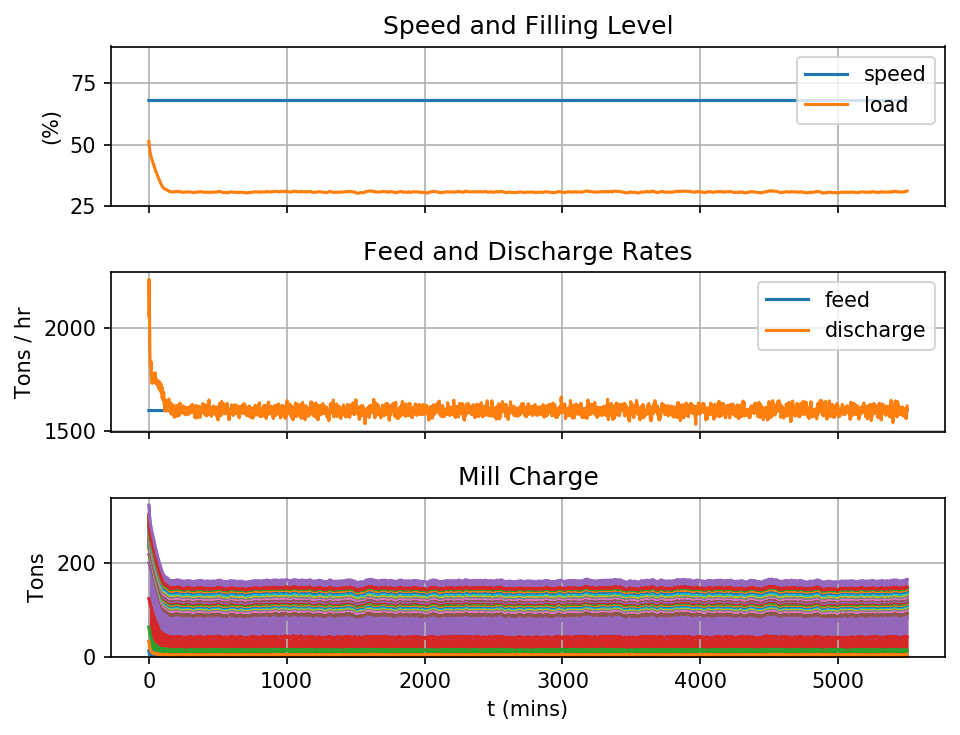

In [8]:
plot_sim_results(sim_data, figsize=(6.5,5),
                 filename = f"sim_results_1_{nt}.png")

## Dynamic Mode Decomposition with Control (DMDc)

In [9]:
from pydmd import DMD, DMDc

In [10]:
# Prepare lists of labels
makeup_feed_labels = [col for col in sim_data if col.startswith('Make-up Feed [')]
mill_discharge_feed_labels = [col for col in sim_data if col.startswith('Mill Discharge [')]
internal_charge_labels = [col for col in sim_data if col.startswith('Internal Charge [')]

n = 25
assert len(makeup_feed_labels) == n
assert len(mill_discharge_feed_labels) == n
assert len(internal_charge_labels) == n

In [11]:
# Prepare data for DMD

# Ignore the first 1000 timesteps
k_start = 1000
nk = 10000

x_data = sim_data.loc[k_start:k_start+nk-1, internal_charge_labels].values.T
u_data = sim_data.loc[k_start:k_start+nk-2, makeup_feed_labels].values.T
t = sim_data.loc[k_start:k_start+nk-1, 'Time (mins)']

assert x_data.shape == (n, nk)
assert u_data.shape == (n, nk-1)

x_data.shape, u_data.shape

((25, 10000), (25, 9999))

In [12]:
dmdc = DMDc(svd_rank=-1)
dmdc.fit(x_data, u_data)

dmdc.atilde.shape, dmdc.B.shape

((25, 25), (25, 25))

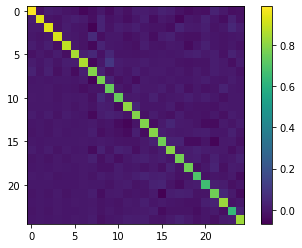

In [13]:
# Visualize A matrix
plt.imshow(dmdc.atilde, cmap='viridis')
plt.colorbar()
#filename = "b_matrix_cmap.pdf"
#plt.savefig(os.path.join(plot_dir, filename))
plt.show()

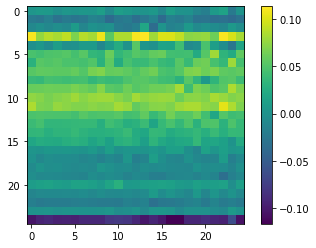

In [14]:
# Visualize B matrix
plt.imshow(dmdc.B, cmap='viridis')
plt.colorbar()
#filename = "b_matrix_cmap.pdf"
#plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [15]:
# Reconstructing data from model
dmdc.reconstructed_data().real.shape

(25, 10000)

In [16]:
dmdc.modes.shape

(25, 25)

In [17]:
# Eigenvalues of A\tilde
dmdc.eigs.shape

(25,)

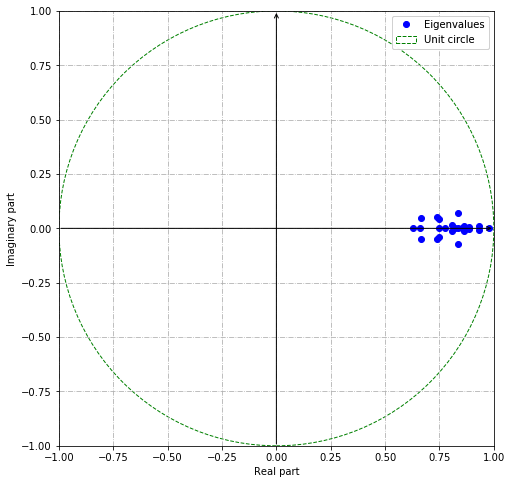

In [18]:
dmdc.plot_eigs(show_axes=True, show_unit_circle=True)

In [19]:
# Compare projections with DMD model

In [20]:
charge_weights = sim_data.loc[k_start:k_start+nk-1].set_index('Time (mins)')[internal_charge_labels]
charge_weights.head()

,Internal Charge [1],Internal Charge [2],Internal Charge [3],Internal Charge [4],Internal Charge [5],Internal Charge [6],Internal Charge [7],Internal Charge [8],Internal Charge [9],Internal Charge [10],...,Internal Charge [16],Internal Charge [17],Internal Charge [18],Internal Charge [19],Internal Charge [20],Internal Charge [21],Internal Charge [22],Internal Charge [23],Internal Charge [24],Internal Charge [25]
Time (mins),,,,,,,,,,,,,,,,,,,,,
500.5,0.682299,3.531050,10.318023,28.502192,38.547925,10.794411,7.043784,3.041888,2.901262,2.273477,...,2.861860,3.130179,3.114661,3.243189,3.119987,3.093263,2.858972,2.744759,2.469475,15.806709
501.0,1.060462,3.450032,10.280567,28.568004,38.497617,10.607609,7.262547,3.005401,2.655628,2.387156,...,2.927653,3.113416,3.134923,3.344045,3.146718,3.105797,2.843842,2.759252,2.405414,15.627944
501.5,1.161486,3.717708,10.036240,28.514971,38.858725,10.872029,7.093243,3.182727,2.619331,2.308320,...,2.945549,3.037224,3.207534,3.243253,3.066187,3.037021,2.787736,2.749118,2.355919,15.516890
502.0,1.413453,3.991318,10.199152,28.209724,39.052679,10.805939,7.006975,3.474658,2.642979,2.190087,...,3.036672,3.080728,3.094926,3.242781,3.047970,2.994855,2.730461,2.751095,2.348954,15.417304
502.5,1.133664,4.292188,10.535246,28.083977,38.430912,10.445591,7.075257,3.521043,2.825031,2.280228,...,2.839866,3.225603,3.222781,3.355271,3.182477,2.968720,2.677155,2.781295,2.330581,15.620457


In [21]:
# Reconstruct trajectories from DMD
charge_weights_recon = pd.DataFrame(
    dmdc.reconstructed_data().real.T,
    index=t,
    columns=charge_weights.columns.to_list()
)
charge_weights_recon.shape

(10000, 25)

In [22]:
# Check for negative values (charge weights cannot be negative)
neg_values = (charge_weights_recon < 0)
count_negs = neg_values.to_numpy().sum()
assert count_negs == 0
charge_weights_recon[neg_values] = np.nan
count_negs

0

In [23]:
# Compute a reduced order model with DMDc
r = 5

# Ignore the first 1000 timesteps
n = 25
k_start = 1000
nk = 10000
x_data = sim_data.loc[k_start:k_start+nk-1, internal_charge_labels].values.T
u_data = sim_data.loc[k_start:k_start+nk-2, makeup_feed_labels].values.T
t = sim_data.loc[k_start:k_start+nk-1, 'Time (mins)']

assert x_data.shape == (n, nk)
assert u_data.shape == (n, nk-1)

dmdc_red = DMDc(svd_rank=r)
dmdc_red.fit(x_data, u_data)

In [24]:
charge_weights_recon_red = pd.DataFrame(
    dmdc_red.reconstructed_data().real.T,
    index=t,
    columns=charge_weights.columns.to_list()
)
charge_weights_recon_red.shape

(10000, 25)

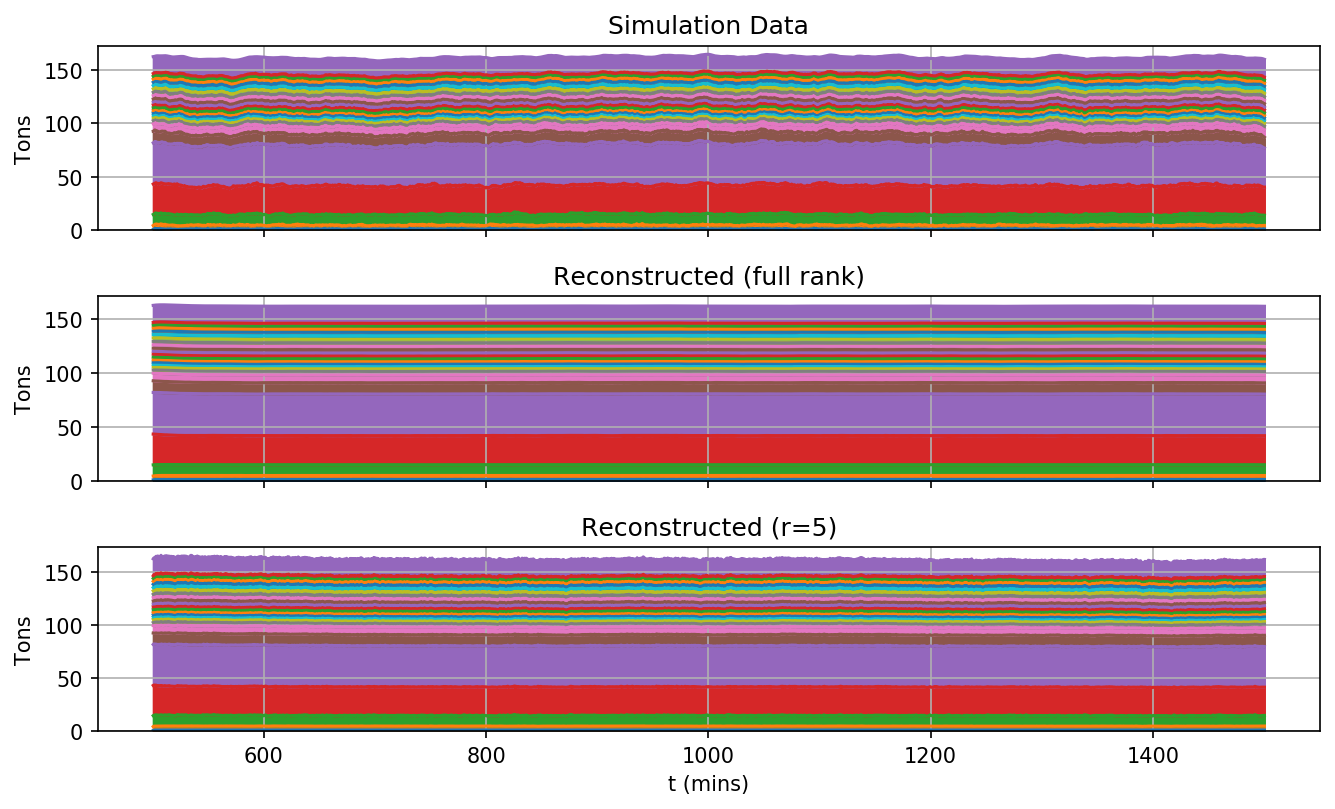

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(9,5.5), sharex=True)

fig.dpi = 150

style = '-' if charge_weights_recon.shape[0] > 51 else '.-'

t1, t2 = 500.5, 1500.5

ax = axes[0]
charge_weights.loc[t1:t2].plot.area(ax=ax, stacked=True, legend=False)
ax.set_title('Simulation Data')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()

ax = axes[1]
charge_weights_recon.loc[t1:t2].plot.area(ax=ax, stacked=True, legend=False)
ax.set_title(f'Reconstructed (full rank)')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()

ax = axes[2]
charge_weights_recon_red.loc[t1:t2].plot.area(ax=ax, stacked=True, legend=False)
ax.set_title(f'Reconstructed (r={dmdc_red.svd_rank})')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()

plt.tight_layout()
#if filename:
#    plt.savefig(os.path.join(plot_dir, filename))
plt.show()

## My code for DMDc

In [26]:
# Compute dynamic matrix decomposition for a system
# with control inputs (DMDc).

# Ignore the first 1000 timesteps
k_start = 1000
nk = 10000

x_data = sim_data.loc[k_start:k_start+nk-1, internal_charge_labels].values
u_data = sim_data.loc[k_start:k_start+nk-2, makeup_feed_labels].values
t = sim_data.loc[k_start:k_start+nk-1, 'Time (mins)']

x = x_data[:-1].T
x2 = x_data[1:].T
u = u_data.T
r = 10

print(x.shape, u.shape)

omega = np.vstack([x, u])
omega.shape

(25, 9999) (25, 9999)


(50, 9999)

In [27]:
u, sigma, vh = np.linalg.svd(omega, full_matrices=False)

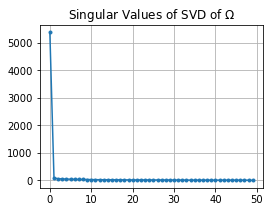

In [28]:
plt.figure(figsize=(4,3))
plt.plot(sigma, '.-')
plt.title('Singular Values of SVD of $\Omega$')
plt.grid()
plt.show()

## Simulation 2 - closed loop with input excitation

In [29]:
# Read data from file
data_filename = 'sim_clis_2020-04-13.csv'
filepath = os.path.join(data_dir, data_filename)
sim_data = pd.read_csv(filepath)
nt = sim_data.shape[0]
sim_data.shape

(11000, 83)

In [30]:
sim_data.head()

,Timestep,Time (mins),Charge Filling (%),Speed (% Critical),Power (kW),Make-up Feed [1],Make-up Feed [2],Make-up Feed [3],Make-up Feed [4],Make-up Feed [5],...,Mill Discharge [19],Mill Discharge [20],Mill Discharge [21],Mill Discharge [22],Mill Discharge [23],Mill Discharge [24],Mill Discharge [25],Net Feedrate (ton/hr),Mill Discharge (ton/hr),Charge Filling SP (%)
0,0.0,0.5,51.393438,68.0,8984.717927,0.683564,0.654587,0.980051,2.665994,3.351838,...,1.019185,0.978410,0.941030,0.825406,0.812527,0.689978,4.979622,1800.000000,2086.113739,30.7
1,1.0,1.0,50.814753,68.0,9026.134570,0.305696,0.664244,0.910091,1.488350,1.842460,...,1.121699,1.112223,1.043790,0.937088,0.924343,0.882223,5.940930,1051.441814,2169.009057,30.7
2,2.0,1.5,50.267238,68.0,9063.319096,0.379437,0.471396,0.817752,1.808835,2.074605,...,1.182139,1.169216,1.115296,1.019818,1.005057,0.985892,6.491702,1163.271425,2199.728020,30.7
3,3.0,2.0,49.742839,68.0,9097.109492,0.724820,0.492145,1.148102,1.912246,1.964538,...,1.152929,1.190802,1.167539,1.085171,1.108899,1.025332,6.825744,1221.366097,2200.157920,30.7
4,4.0,2.5,49.237841,68.0,9127.962612,0.561115,0.706096,0.722924,2.355721,2.401289,...,1.130029,1.155895,1.186139,1.154697,1.156619,1.017797,7.069071,1248.015962,2182.996905,30.7


In [31]:
sim_data.columns

Index(['Timestep', 'Time (mins)', 'Charge Filling (%)', 'Speed (% Critical)',
       'Power (kW)', 'Make-up Feed [1]', 'Make-up Feed [2]',
       'Make-up Feed [3]', 'Make-up Feed [4]', 'Make-up Feed [5]',
       'Make-up Feed [6]', 'Make-up Feed [7]', 'Make-up Feed [8]',
       'Make-up Feed [9]', 'Make-up Feed [10]', 'Make-up Feed [11]',
       'Make-up Feed [12]', 'Make-up Feed [13]', 'Make-up Feed [14]',
       'Make-up Feed [15]', 'Make-up Feed [16]', 'Make-up Feed [17]',
       'Make-up Feed [18]', 'Make-up Feed [19]', 'Make-up Feed [20]',
       'Make-up Feed [21]', 'Make-up Feed [22]', 'Make-up Feed [23]',
       'Make-up Feed [24]', 'Make-up Feed [25]', 'Internal Charge [1]',
       'Internal Charge [2]', 'Internal Charge [3]', 'Internal Charge [4]',
       'Internal Charge [5]', 'Internal Charge [6]', 'Internal Charge [7]',
       'Internal Charge [8]', 'Internal Charge [9]', 'Internal Charge [10]',
       'Internal Charge [11]', 'Internal Charge [12]', 'Internal Charge [13]'

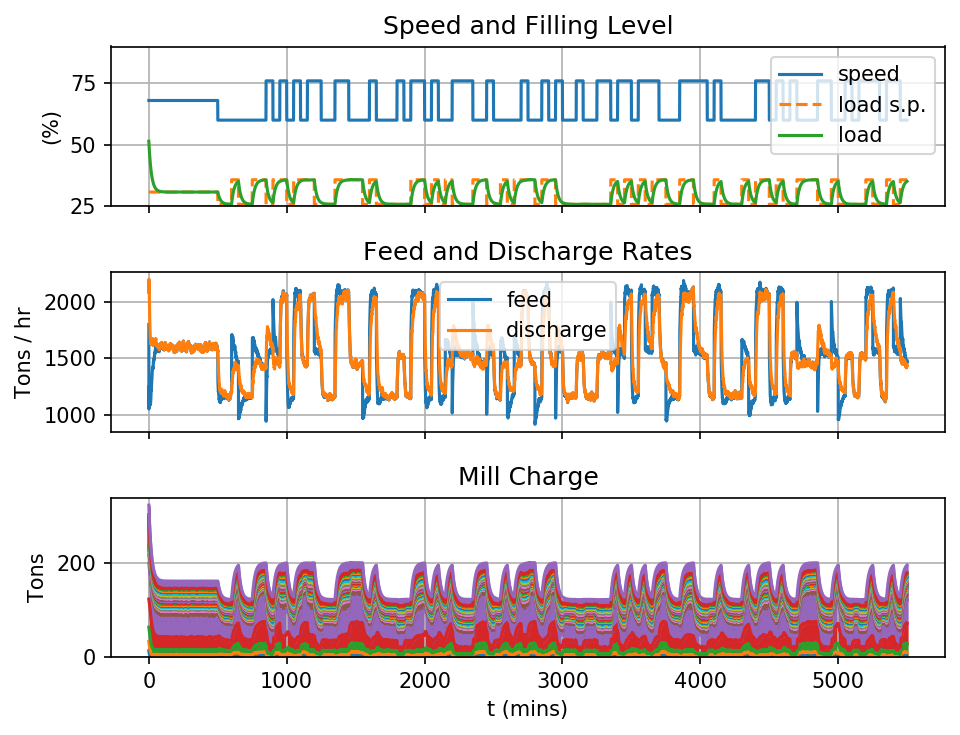

In [32]:
plot_sim_results(sim_data, figsize=(6.5,5),
                 filename = f"sim_results_2_{nt}.png")

## Sparse Identification of Non-Linear Dynamics (SINDy)

In [33]:
import pysindy as ps

In [34]:
sim_data.shape

(11000, 83)

In [35]:
sim_data.columns

Index(['Timestep', 'Time (mins)', 'Charge Filling (%)', 'Speed (% Critical)',
       'Power (kW)', 'Make-up Feed [1]', 'Make-up Feed [2]',
       'Make-up Feed [3]', 'Make-up Feed [4]', 'Make-up Feed [5]',
       'Make-up Feed [6]', 'Make-up Feed [7]', 'Make-up Feed [8]',
       'Make-up Feed [9]', 'Make-up Feed [10]', 'Make-up Feed [11]',
       'Make-up Feed [12]', 'Make-up Feed [13]', 'Make-up Feed [14]',
       'Make-up Feed [15]', 'Make-up Feed [16]', 'Make-up Feed [17]',
       'Make-up Feed [18]', 'Make-up Feed [19]', 'Make-up Feed [20]',
       'Make-up Feed [21]', 'Make-up Feed [22]', 'Make-up Feed [23]',
       'Make-up Feed [24]', 'Make-up Feed [25]', 'Internal Charge [1]',
       'Internal Charge [2]', 'Internal Charge [3]', 'Internal Charge [4]',
       'Internal Charge [5]', 'Internal Charge [6]', 'Internal Charge [7]',
       'Internal Charge [8]', 'Internal Charge [9]', 'Internal Charge [10]',
       'Internal Charge [11]', 'Internal Charge [12]', 'Internal Charge [13]'

In [36]:
# Prepare lists of labels
makeup_feed_labels = [col for col in sim_data if col.startswith('Make-up Feed [')]
assert len(makeup_feed_labels) == 25
mill_discharge_feed_labels = [col for col in sim_data if col.startswith('Mill Discharge [')]
assert len(mill_discharge_feed_labels) == 25
internal_charge_labels = [col for col in sim_data if col.startswith('Internal Charge [')]
assert len(internal_charge_labels) == 25

In [37]:
selected_range = sim_data['Timestep'] >= 1000
u_labels = makeup_feed_labels + ['Speed (% Critical)']
x_labels = internal_charge_labels

t = sim_data.loc[selected_range, 'Time (mins)'].values
X = sim_data.loc[selected_range, x_labels].values
t.shape, X.shape

((10000,), (10000, 25))

In [38]:
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=2)
optimizer = ps.STLSQ(threshold=0.05)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=[f'x{i+1:02d}' for i in range(X.shape[0])]
)

In [39]:
model.fit(X, t=t)

SINDy(differentiation_method=<pysindy.differentiation.finite_difference.FiniteDifference object at 0x151d4de2d0>,
      discrete_time=False,
      feature_library=PolynomialLibrary(degree=2, include_bias=True,
                                        include_interaction=True,
                                        interaction_only=False, order='C'),
      feature_names=['x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08',
                     'x09', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16',
                     'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24',
                     'x25', 'x26', 'x27', 'x28', 'x29', 'x30', ...],
      n_jobs=1,
      optimizer=STLSQ(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=20,
                      normalize=False, ridge_kw=None, threshold=0.05))

In [40]:
model.print()

x01' = -0.515 1 + -0.072 x07 + -0.059 x08 + -0.135 x09 + 0.255 x12 + 0.324 x17 + 0.155 x19 + 0.130 x21 + -0.137 x23 + 0.199 x01 x12 + -0.124 x01 x14 + -0.093 x02 x12 + 0.061 x02 x14 + -0.077 x07 x23 + 0.105 x07 x24 + -0.083 x08 x09 + 0.157 x08 x11 + -0.138 x08 x18 + -0.070 x08 x20 + 0.129 x08 x21 + 0.087 x08 x24 + 0.100 x09 x10 + 0.113 x09 x19 + -0.077 x09 x22 + 0.093 x09 x23 + -0.100 x09 x24 + -0.248 x10 x11 + 0.194 x10 x17 + 0.065 x10 x20 + -0.096 x10 x22 + -0.134 x10 x24 + -0.058 x11 x13 + 0.194 x11 x14 + -0.166 x11 x16 + -0.155 x11 x17 + 0.290 x11 x18 + -0.116 x11 x20 + 0.201 x11 x21 + -0.204 x11 x23 + -0.057 x12 x13 + 0.097 x12 x16 + -0.101 x12 x17 + -0.156 x12 x21 + 0.080 x12 x23 + 0.112 x12 x24 + 0.084 x13^2 + -0.058 x13 x24 + -0.090 x14 x15 + 0.071 x14 x17 + -0.130 x14 x18 + -0.129 x14 x19 + 0.055 x14 x21 + 0.089 x14 x24 + 0.138 x15^2 + -0.227 x15 x17 + 0.106 x15 x19 + 0.125 x15 x20 + -0.285 x15 x21 + 0.144 x15 x23 + 0.073 x16 x17 + 0.077 x16 x18 + -0.109 x16 x20 + -0.074 x16 x

In [41]:
model.get_params()

{'differentiation_method': <pysindy.differentiation.finite_difference.FiniteDifference at 0x151d4de2d0>,
 'discrete_time': False,
 'feature_library__degree': 2,
 'feature_library__include_bias': True,
 'feature_library__include_interaction': True,
 'feature_library__interaction_only': False,
 'feature_library__order': 'C',
 'feature_library': PolynomialLibrary(degree=2, include_bias=True, include_interaction=True,
                   interaction_only=False, order='C'),
 'feature_names': ['x01',
  'x02',
  'x03',
  'x04',
  'x05',
  'x06',
  'x07',
  'x08',
  'x09',
  'x10',
  'x11',
  'x12',
  'x13',
  'x14',
  'x15',
  'x16',
  'x17',
  'x18',
  'x19',
  'x20',
  'x21',
  'x22',
  'x23',
  'x24',
  'x25',
  'x26',
  'x27',
  'x28',
  'x29',
  'x30',
  'x31',
  'x32',
  'x33',
  'x34',
  'x35',
  'x36',
  'x37',
  'x38',
  'x39',
  'x40',
  'x41',
  'x42',
  'x43',
  'x44',
  'x45',
  'x46',
  'x47',
  'x48',
  'x49',
  'x50',
  'x51',
  'x52',
  'x53',
  'x54',
  'x55',
  'x56',
  'x57

In [42]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 'coefficients',
 'complexity',
 'differentiate',
 'differentiation_method',
 'discrete_time',
 'equations',
 'feature_library',
 'feature_names',
 'fit',
 'get_feature_names',
 'get_params',
 'model',
 'n_input_features_',
 'n_jobs',
 'n_output_features_',
 'optimizer',
 'predict',
 'print',
 'process_multiple_trajectories',
 'score',
 'set_params',
 'simulate']

## Compare linear models from DMDc to non-linear system under excitation

In [43]:
# Feed rates from simulation
u_data = sim_data.set_index('Time (mins)')[makeup_feed_labels].values[:-1]
u_data.shape

(10999, 25)

In [44]:
# Charge weights from simulation
charge_weights = sim_data.set_index('Time (mins)')[internal_charge_labels]
charge_weights.shape

(11000, 25)

In [45]:
# Initial charge
x0 = x_data[0]
x0.shape

(25,)

In [46]:
# Compute A matrix from DMDc above
A = dmdc.modes.dot(np.diag(dmdc.eigs)).dot(np.linalg.pinv(dmdc.modes))
A.shape

(25, 25)

In [47]:
B = dmdc.B
B.shape

(25, 25)

In [48]:
# Reconstruct system outputs from inputs and initial condition
data = [x0]

for i, u in enumerate(u_data):
    data.append((A.dot(data[i]) + B.dot(u)).real)

charge_weights_recon = pd.DataFrame(
    np.array(data),
    index=charge_weights.index,
    columns=charge_weights.columns.to_list()
)

charge_weights_recon.shape

(11000, 25)

In [49]:
# Repeat for the reduced model
A = dmdc_red.modes.dot(np.diag(dmdc_red.eigs)).dot(np.linalg.pinv(dmdc_red.modes))
B = dmdc_red.B

# Reconstruct system outputs from inputs and initial condition
data = [x0]

for i, u in enumerate(u_data):
    data.append((A.dot(data[i]) + B.dot(u)).real)

charge_weights_recon_red = pd.DataFrame(
    np.array(data),
    index=charge_weights.index,
    columns=charge_weights.columns.to_list()
)

charge_weights_recon_red.shape

(11000, 25)

In [50]:
charge_weights_recon.head()

,Internal Charge [1],Internal Charge [2],Internal Charge [3],Internal Charge [4],Internal Charge [5],Internal Charge [6],Internal Charge [7],Internal Charge [8],Internal Charge [9],Internal Charge [10],...,Internal Charge [16],Internal Charge [17],Internal Charge [18],Internal Charge [19],Internal Charge [20],Internal Charge [21],Internal Charge [22],Internal Charge [23],Internal Charge [24],Internal Charge [25]
Time (mins),,,,,,,,,,,,,,,,,,,,,
0.5,0.682299,3.531050,10.318023,28.502192,38.547925,10.794411,7.043784,3.041888,2.901262,2.273477,...,2.861860,3.130179,3.114661,3.243189,3.119987,3.093263,2.858972,2.744759,2.469475,15.806709
1.0,0.787202,3.470801,10.284639,28.560107,38.614064,10.805653,7.157316,3.211212,2.925685,2.401742,...,2.926805,3.113135,3.127969,3.233071,3.125210,3.133617,2.871563,2.725561,2.467654,15.638221
1.5,0.840805,3.591604,10.298025,28.055686,38.624001,10.526834,6.971678,2.985434,2.689486,2.113410,...,2.830466,3.092201,3.190028,3.266871,3.195597,3.086531,2.937058,2.837909,2.472888,16.113846
2.0,0.874928,3.663656,10.285343,27.684522,38.628982,10.318640,6.844661,2.880637,2.542564,1.943339,...,2.751919,3.045347,3.206560,3.263299,3.217962,3.041039,2.957435,2.894049,2.460442,16.369213
2.5,0.887305,3.702491,10.286001,27.399354,38.611289,10.175432,6.754730,2.825690,2.443007,1.843882,...,2.669810,2.992413,3.192097,3.238760,3.210511,3.003657,2.953801,2.916002,2.437446,16.472006


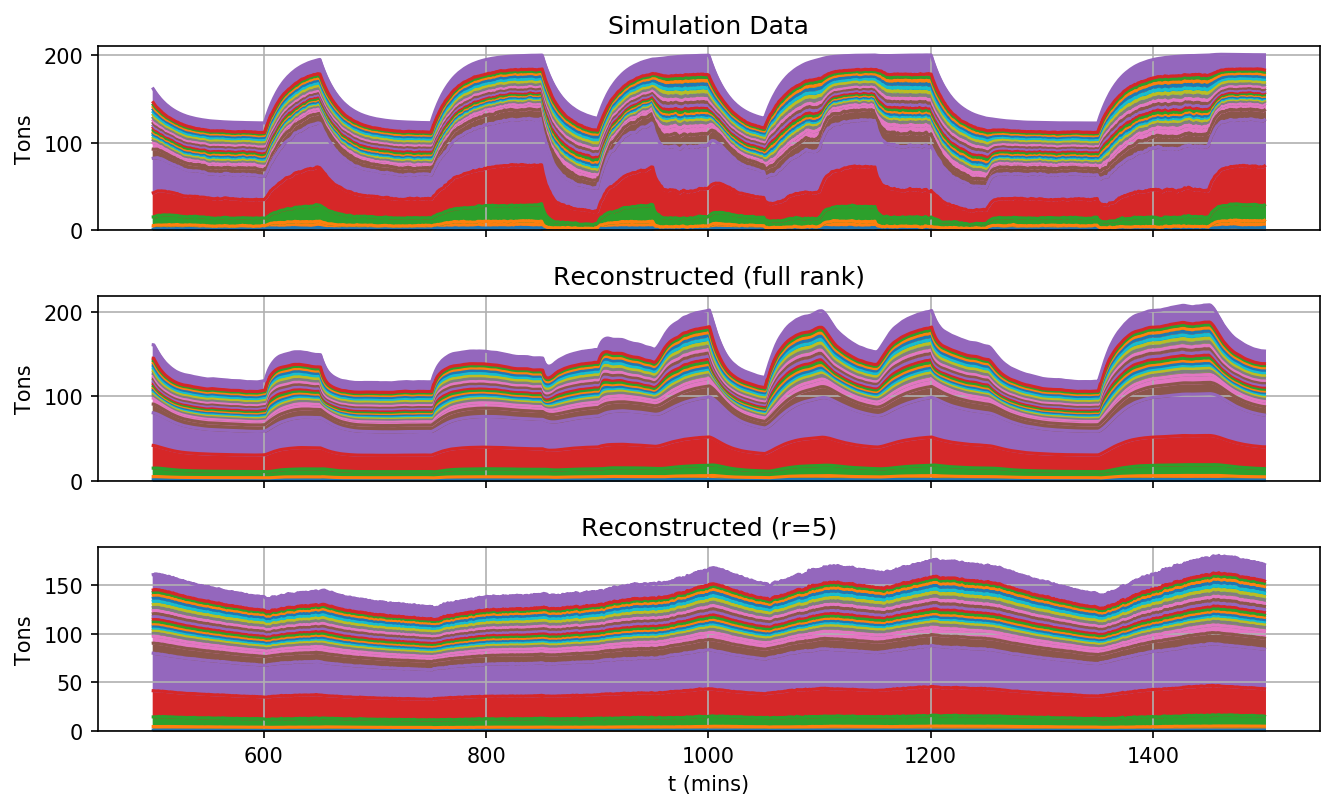

In [51]:
fig, axes = plt.subplots(3, 1, figsize=(9,5.5), sharex=True)

fig.dpi = 150

style = '-' if charge_weights_recon.shape[0] > 51 else '.-'

t1, t2 = 500.5, 1500.5

ax = axes[0]
charge_weights.loc[t1:t2].plot.area(ax=ax, stacked=True, legend=False)
ax.set_title('Simulation Data')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()

ax = axes[1]
charge_weights_recon.loc[t1:t2].plot.area(ax=ax, stacked=True, legend=False)
ax.set_title(f'Reconstructed (full rank)')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()

ax = axes[2]
charge_weights_recon_red.loc[t1:t2].plot.area(ax=ax, stacked=True, legend=False)
ax.set_title(f'Reconstructed (r={dmdc_red.svd_rank})')
ax.set_xlabel('t (mins)')
ax.set_ylabel('Tons')
ax.grid()

plt.tight_layout()
filename = 'sim_results_2_dmd.png'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()